## Mount to Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import torch
import torch.nn as nn
import torchvision
from google.colab import files

from torchvision import transforms
files.upload()
from modules import train_model, test_model
from torch import optim
from torch.optim import lr_scheduler
from datetime import datetime
import pandas as pd
files.upload()
from backbone_models import ResNet18, VGG16
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.utils.data as data

Saving modules.py to modules.py


Saving backbone_models.py to backbone_models.py


In [5]:
ppg_dir = '/content/drive/MyDrive/Data/5459299/Data_File/subject'
label_path = '/content/drive/MyDrive/Data/5459299/Data_File/PPG-BP dataset.csv'

## Choose High Quality Data
(From the dataset description, it says every subject has 3 segments of ppg signals, and we need to choose the segment with highest quality for each subject.)
(But for now, we just choose all segments as long as the quality is positive, so we can have more data to train.)

In [6]:
# organized data from https://www.nature.com/articles/sdata201820/tables/2

quality_dict = dict()
# key: subject number; value[0]: subject ID; value[1]:quality of segment 1; value[2]:quality of segment 2; value[3]:quality of segment 3
quality_dict[1] = [2, 0.98, 0.96, 0.92]
quality_dict[2] = [3, 0.69, 0.8, 0.81]
quality_dict[3] = [6, 0.58, 0.59, 0.64]
quality_dict[4] = [8, 0.96, 0.85, 0.87]
quality_dict[5] = [9, 0.65, 0.67, 0.87]
quality_dict[6] = [10, 0.59, 0.64, 0.34]
quality_dict[7] = [11, 0.74, 0.67, -0.16]
quality_dict[8] = [12, 0.23, 0.73, 0.41]
quality_dict[9] = [13, 0.76, 0.84, 1.06]
quality_dict[10] = [14, 0.77, 0.72, 0.15]

quality_dict[11] = [15, 1.23, 0.77, 0.3]
quality_dict[12] = [16, 0.64, 0.66, 0.83]
quality_dict[13] = [17, 0.69, 0.9, 0.9]
quality_dict[14] = [18, 0.87, 0.59, 1.05]
quality_dict[15] = [19, 0.78, 0.19, 0.16]
quality_dict[16] = [21, 0.65, 0.74, 0.75]
quality_dict[17] = [22, 0.73, 0.44, 0.39]
quality_dict[18] = [23, 0.7, 0.6, 0.74]
quality_dict[19] = [24, 0.74, 0.74, 0.75]
quality_dict[20] = [25, 1.38, 0.15, 0.78]

quality_dict[21] = [26, 1.31, 0.47, 0.83]
quality_dict[22] = [27, 1.86, 1.33, 1.26]
quality_dict[23] = [29, 0.73, 0.6, -0.05]
quality_dict[24] = [30, 0.86, 0.8, 0.76]
quality_dict[25] = [31, 0.68, 0.81, 0.7]
quality_dict[26] = [32, 1.06, 1.12, 1.23]
quality_dict[27] = [34, 0.9, 0.79, 0.74]
quality_dict[28] = [35, 0.94, 1.15, 1.18]
quality_dict[29] = [38, 0.88, 0.66, 0.94]
quality_dict[30] = [40, 0.21, 1.2, 0.9]

quality_dict[31] = [41, 0.85, 0.78, 0.73]
quality_dict[32] = [43, 0.52, 0.28, 0.53]
quality_dict[33] = [45, 0.68, 0.76, 0.67]
quality_dict[34] = [47, 0.76, 0.75, 0.73]
quality_dict[35] = [48, 0.74, 0.79, 0.63]
quality_dict[36] = [50, 0.79, 0.72, 0.73]
quality_dict[37] = [51, 0.6, 0.2, 0.49]
quality_dict[38] = [52, 0.95, 0.67, 0.93]
quality_dict[39] = [53, 0.81, 0.91, 0.9]
quality_dict[40] = [54, 1.12, 1.06, 1.11]

quality_dict[41] = [55, 0.63, 0.99, 1.1]
quality_dict[42] = [56, 0.26, 0.4, 0.47]
quality_dict[43] = [57, 0.69, 0.59, 0.65]
quality_dict[44] = [58, 0.97, 0.62, 0.75]
quality_dict[45] = [60, 0.37, 1.64, 0.51]
quality_dict[46] = [61, 0.87, 0.84, 0.93]
quality_dict[47] = [62, 0.57, 0.96, 0.69]
quality_dict[48] = [63, 1.01, 0.92, 0.92]
quality_dict[49] = [64, 0.19, 0.65, 0.39]
quality_dict[50] = [65, 0.78, 0.8, 0.72]

quality_dict[51] = [66, 0.79, 0.79, 0.94]
quality_dict[52] = [67, 0.7, 0.7, 0.99]
quality_dict[53] = [83, 0.81, 0.9, 0.79]
quality_dict[54] = [84, 0.91, 0.3, 0.65]
quality_dict[55] = [85, 0.68, 0.79, 0.63]
quality_dict[56] = [86, 0.66, 0.7, 0.72]
quality_dict[57] = [87, 0.97, 0.96, 0.95]
quality_dict[58] = [88, 0.81, 0.52, 0.65]
quality_dict[59] = [89, 0.39, 0.58, 0.14]
quality_dict[60] = [90, 0.87, 0.97, 1]

quality_dict[61] = [91, 1.05, 0.77, 0.84]
quality_dict[62] = [92, 0.9, 1.1, 1.15]
quality_dict[63] = [93, 0.97, 0.99, 0.46]
quality_dict[64] = [95, 1.31, 0.89, 0.87]
quality_dict[65] = [96, 0.75, 0.89, 0.81]
quality_dict[66] = [97, 0.56, 0.42, 0.76]
quality_dict[67] = [98, 0.88, 0.98, 0.86]
quality_dict[68] = [99, 0.88, 0.72, 0.79]
quality_dict[69] = [100, 0.58, 0.66, 0.16]
quality_dict[70] = [103, 0.37, 0.4, 0.44]

quality_dict[71] = [104, 0.88, 0.23, 0.85]
quality_dict[72] = [105, 0.54, 0.97, 0.8]
quality_dict[73] = [106, 0.82, 0.9, 1.16]
quality_dict[74] = [107, 0.89, 0.58, 0.66]
quality_dict[75] = [108, 0.71, 0.69, 0.64]
quality_dict[76] = [110, 0.9, 0.83, 0.88]
quality_dict[77] = [111, 0.9, 0.85, 0.76]
quality_dict[78] = [112, 0.61, 0.55, 0.57]
quality_dict[79] = [113, 0.35, 0.51, 0.78]
quality_dict[80] = [114, 0.5, 0.58, 0.67]

quality_dict[81] = [115, 0.74, 0.06, 1.03]
quality_dict[82] = [116, 0.78, 0.86, 0.93]
quality_dict[83] = [119, 0.55, 0.59, -0.07]
quality_dict[84] = [120, 0.79, 0.67, 0.77]
quality_dict[85] = [122, 0.93, 0.87, 0.5]
quality_dict[86] = [123, 0.89, 0.97, 1.3]
quality_dict[87] = [124, 0.93, 1.23, 1.19]
quality_dict[88] = [125, 0.84, -0.47, 0.86]
quality_dict[89] = [126, 0.44, -0.01, 0.54]
quality_dict[90] = [127, 0.53, 0.83, 0.75]

quality_dict[91] = [128, 0.87, 0.86, 0.9]
quality_dict[92] = [130, 0.91, 0.97, 1]
quality_dict[93] = [131, 0.86, 0.85, 0.75]
quality_dict[94] = [134, 0.71, 0.21, 0.86]
quality_dict[95] = [135, 0.68, 0.72, 0.67]
quality_dict[96] = [136, 1.73, 0.56, 0.8]
quality_dict[97] = [137, 0.28, 0.58, 0.79]
quality_dict[98] = [138, 0.74, 0.48, 0.59]
quality_dict[99] = [139, 1.35, 0.69, 0.63]
quality_dict[100] = [140, 0.41, 0.85, 0.71]

quality_dict[101] = [141, 1.14, 0.96, 0.86]
quality_dict[102] = [142, 0.8, 0.82, 0.83]
quality_dict[103] = [144, 0.76, 0.66, -0.01]
quality_dict[104] = [145, 1.11, 1.1, 1.1]
quality_dict[105] = [146, 0.84, 0.84, 1]
quality_dict[106] = [148, 1.03, 1.03, 1.06]
quality_dict[107] = [149, 0.52, 0.58, 0.49]
quality_dict[108] = [150, 0.75, 0.66, 0.49]
quality_dict[109] = [151, 0.81, 0.29, 0.85]
quality_dict[110] = [152, 1.05, 0.9, 1.22]

quality_dict[111] = [153, 0.93, 1.15, 0.79]
quality_dict[112] = [154, 0.82, 0.7, 0.75]
quality_dict[113] = [155, 0.75, 0.94, 0.71]
quality_dict[114] = [156, 0.75, 0.76, 0.7]
quality_dict[115] = [157, 0.58, 0.68, 0.44]
quality_dict[116] = [158, 0.66, 0.86, 0.05]
quality_dict[117] = [160, 0.54, 0.66, 0.59]
quality_dict[118] = [161, 0.89, 0.83, 0.86]
quality_dict[119] = [162, 1.07, 1, 0.97]
quality_dict[120] = [163, 0.79, 0.42, 0.61]

quality_dict[121] = [164, 0.94, 0.85, 0.71]
quality_dict[122] = [165, 1.07, 0.96, 1.02]
quality_dict[123] = [166, 0.71, 0.93, 0.77]
quality_dict[124] = [167, 0.57, 0.76, 0.57]
quality_dict[125] = [169, 1.11, 0.82, 0.91]
quality_dict[126] = [170, 0.77, 0.85, 0.95]
quality_dict[127] = [171, 0.69, 0.46, 0.48]
quality_dict[128] = [172, 0.45, 0.56, 0.53]
quality_dict[129] = [173, 0.89, 0.84, 0.97]
quality_dict[130] = [174, 1.14, 1.03, 1.17]

quality_dict[131] = [175, 0.69, 0.62, 0.71]
quality_dict[132] = [176, 0.75, 0.73, 0.68]
quality_dict[133] = [178, 0.38, 0.68, 0.55]
quality_dict[134] = [179, 2.34, 0.83, 0.78]
quality_dict[135] = [180, 0.8, 0.64, 0.84]
quality_dict[136] = [182, 0.72, 0.93, 0.9]
quality_dict[137] = [183, 0.35, 0.25, 0.36]
quality_dict[138] = [184, 0.49, 0.93, 0.87]
quality_dict[139] = [185, 1.03, 1.1, 1.1]
quality_dict[140] = [186, 0.73, 0.69, 0.99]

quality_dict[141] = [188, 0.85, 1.78, 0.71]
quality_dict[142] = [189, 0.9, 0.68, 0.92]
quality_dict[143] = [190, 1.13, 0.8, 0.99]
quality_dict[144] = [191, 1.23, 1.1, 0.85]
quality_dict[145] = [192, 0.85, 0.87, 0.8]
quality_dict[146] = [193, 0.76, 0.53, 0.63]
quality_dict[147] = [195, 0.91, 1.1, 0.49]
quality_dict[148] = [196, 0.88, 0.74, 0.68]
quality_dict[149] = [197, 0.9, 1.06, 1.33]
quality_dict[150] = [198, 1.12, 1.07, 1.02]

quality_dict[151] = [199, 0.81, 0.96, 0.83]
quality_dict[152] = [200, 0.3, 0.86, 1.02]
quality_dict[153] = [201, 0.68, 0.69, 0.8]
quality_dict[154] = [203, 0.92, 1.05, 0.86]
quality_dict[155] = [205, 0.91, 0.82, 0.77]
quality_dict[156] = [206, 0.69, 0.84, 0.67]
quality_dict[157] = [207, 0.75, 0.7, 0.2]
quality_dict[158] = [208, 1.47, 0.95, 0.92]
quality_dict[159] = [209, 0.76, 0.67, 0.7]
quality_dict[160] = [210, 0.72, 0.71, 0.78]

quality_dict[161] = [211, 1.4, 0.73, 0.89]
quality_dict[162] = [212, 0.74, 0.56, 0.59]
quality_dict[163] = [213, 1.16, 0.91, 0.67]
quality_dict[164] = [214, 0.46, 0.72, 0.24]
quality_dict[165] = [215, 0.62, 0.69, 0.81]
quality_dict[166] = [216, 0.33, 0.33, 0.37]
quality_dict[167] = [217, 0.69, 1.26, 0.8]
quality_dict[168] = [218, 0.82, 0.99, 0.89]
quality_dict[169] = [219, 1.02, 1.05, 0.84]
quality_dict[170] = [220, 0.63, 0.65, 0.66]

quality_dict[171] = [221, 0.43, 0.78, 0.6]
quality_dict[172] = [222, 0.92, 0.87, 0.85]
quality_dict[173] = [223, 0.81, 0.08, 0.98]
quality_dict[174] = [224, 0.85, 1.03, 0.75]
quality_dict[175] = [226, 0.84, 1.04, 0.44]
quality_dict[176] = [227, 0.99, 0.88, 0.94]
quality_dict[177] = [228, 1.06, 1, 0.93]
quality_dict[178] = [229, 1, 1.09, 0.98]
quality_dict[179] = [230, 0.59, 0.72, 0.81]
quality_dict[180] = [231, 1.28, 1.46, 0.98]

quality_dict[181] = [232, 0.92, 1.21, 0.87]
quality_dict[182] = [233, 0.89, 0.86, 0.67]
quality_dict[183] = [234, 0.62, 0.81, 1.02]
quality_dict[184] = [235, 0.94, 1.08, 0.97]
quality_dict[185] = [237, 0.79, 1.19, 1.42]
quality_dict[186] = [239, 0.81, 0.8, 0.7]
quality_dict[187] = [240, 0.6, 1.09, 0.93]
quality_dict[188] = [241, 0.68, 0.58, 0.52]
quality_dict[189] = [242, 0.59, 0.7, 0.69]
quality_dict[190] = [243, 1.09, 0.84, 0.91]

quality_dict[191] = [244, 0.73, 0.79, 0.68]
quality_dict[192] = [245, 0.56, 0.54, 7.13]
quality_dict[193] = [246, 1.23, 1.85, 0.63]
quality_dict[194] = [247, 0.8, 0.66, 0.54]
quality_dict[195] = [248, 0.14, 0.65, 0.69]
quality_dict[196] = [250, 0.79, 0.84, 0.77]
quality_dict[197] = [251, 0.99, 0.95, 0.99]
quality_dict[198] = [252, 0.78, 0.38, 10.22]
quality_dict[199] = [253, 0.8, 0.89, 0.92]
quality_dict[200] = [254, 0.51, 0.84, 0.75]

quality_dict[201] = [256, 0.95, 0.72, 1.25]
quality_dict[202] = [257, 0.63, 0.69, 0.87]
quality_dict[203] = [259, 0.59, 0.62, 0.67]
quality_dict[204] = [403, 0.92, 0.92, 0.92]
quality_dict[205] = [404, 1.4, 1, 0.96]
quality_dict[206] = [405, 0.72, 0.79, 0.96]
quality_dict[207] = [406, 0.28, 0.45, 0.54]
quality_dict[208] = [407, 0.84, 0.82, 0.76]
quality_dict[209] = [409, 0.84, 1, 0.89]
quality_dict[210] = [410, 0.94, 0.91, 0.9]

quality_dict[211] = [411, 1.09, 0.92, 1.05]
quality_dict[212] = [412, 0.95, 0.7, 0.99]
quality_dict[213] = [413, 0.74, 0.67, 0.63]
quality_dict[214] = [414, 0.93, 1.34, 1.4]
quality_dict[215] = [415, 1.15, 1.38, 1.19]
quality_dict[216] = [416, 0.96, 0.94, 1.01]
quality_dict[217] = [417, 1.12, 1.32, 1.38]
quality_dict[218] = [418, 0.96, 0.87, 1.06]
quality_dict[219] = [419, 1.13, 1, 0.81]


## Select all segments with positive quality.

In [7]:
# most of data have three segments, only few of them have some negative quality segments
# -> just throw away those segments
not_choose = []
for subject, segment in quality_dict.items():
  for seg, quality in enumerate(quality_dict[subject]):
    if quality < 0:
      not_choose.append((subject, seg))

print(not_choose)
print(len(not_choose))

[(7, 3), (23, 3), (83, 3), (88, 2), (89, 2), (103, 3)]
6


## Setup Dataset

In [8]:
class BPDataset(data.Dataset):
    
    def __init__(self, ppg_dir, label_path, normalize, choose_class=[0,1,2]):

        self.ppg_dir = ppg_dir
        self.label_path = label_path
        self.data = []
        self.label = []
        self.subjectid = []
        self.normalize=normalize
        
        # read BP labels (Label: 'Stage 1 hypertension' or 'Stage 2 hypertension'-> 2; 'Prehypertension'-> 1; 'Normal'-> 0)
        df = pd.read_csv(label_path, skiprows=1)
        #print(set(df["Hypertension"]))
        # choose class
        class_id = [[] for i in range(3)]
        for subject in range(219):
          if df['Hypertension'][subject] == 'Stage 1 hypertension' or df['Hypertension'][subject] == 'Stage 2 hypertension':
            class_id[2].append(subject+1)
          elif df['Hypertension'][subject] == 'Prehypertension':
            class_id[1].append(subject+1)
          elif df['Hypertension'][subject] == 'Normal':
            class_id[0].append(subject+1)

        for c in choose_class:
          # c=0,1,2
          for subject in class_id[c]:
            subjectid = quality_dict[subject][0]
            if subject == 180:
              continue
            elif subject in [7, 23, 83, 88, 89, 103]:
              self.label.extend([c]*2)
            else:
              self.label.extend([c]*3)
            # read ppg data
            for segnum in range(1, 4):
              if (subject, segnum) not in [(7, 3), (23, 3), (83, 3), (88, 2), (89, 2), (103, 3), (180, 1), (180, 2), (180, 3)]:
                ppg_path = os.path.join(ppg_dir, '{}_{}.txt'.format(subjectid, segnum))
                if os.path.exists(ppg_path):
                  with open(ppg_path) as f:
                    lines = f.readlines()[0].split('\t')[:-1]
                    if len(lines) != 2100:
                      print(subject, subjectid, segment, len(lines))
                      continue
                    ppg = torch.Tensor([float(x) for x in lines])
                    ppg = ppg.reshape((1,2100))
                    self.data.append(ppg)
                    self.subjectid.append(subjectid)
        self.label = torch.Tensor(self.label)
        self.label = self.label.type(torch.long)
        
    def __getitem__(self, index):
        data = self.data[index]
        data = (data-self.normalize['mean'])/self.normalize['std'] #normalization
        label = self.label[index]
        subjectid = self.subjectid[index]
        return data, label, subjectid

    def __len__(self):
        return len(self.data)

## 2-Class classification (Sigmoid)
\["Normal", "Prehypertension"]: choose_class=\[0,1]  

\["Normal", "hypertension"]: choose_class=\[0,2]

## Utils (Define lr_decay, calculate accuracy, sensitivity, specificity)

In [25]:
def lr_decay(optimizer, decay_rate=.9):
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * decay_rate

class averageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(1.0 / batch_size))
    return res

In [73]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 23.1 MB/s eta 0:00:00


## Define train, validation functions

In [80]:
from torchmetrics import ConfusionMatrix

def train(data_loader, model, optimizer, epoch, criterion, binary=False):

    losses = averageMeter()
    ACC = averageMeter()

    # setup training mode
    model.train()

    for (step, value) in enumerate(data_loader):

        data = value[0].cuda()
        target = value[1].cuda(non_blocking=True)

        # forward
        output = model(data).squeeze()

        # compute loss
        if not binary:
            loss = criterion(output, target)
        else:
            loss = criterion(output, target.float())
        losses.update(loss.item(), data.size(0))

        # compute acc
        if not binary:
            pred = torch.max(output, dim=1)[1].data.cpu().numpy()
            acc = accuracy(output, target, topk=(1,))[0]
        else:
            pred = torch.gt(output, 0.5).long()
            acc = (target == pred).float().mean()
        ACC.update(acc.item(), data.size(0))

        # compute confusion matrix
        # confmat = ConfusionMatrix(task="multiclass", num_classes=2)
        # conf = confmat(pred, target)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # logging
    curr_lr = optimizer.param_groups[0]['lr']
    print('Epoch: [{}/{}]\t' \
        'LR: [{:.6g}]\t' \
        'Loss {loss.avg:.4f}\t' \
        'Acc {acc.avg:.3f}'.format(
            epoch + 1, n_epoch, curr_lr, loss=losses, acc=ACC
        )
    )
    return ACC.avg, losses.avg#, conf


def val(data_loader, model, criterion, binary=False):

    losses = averageMeter()
    ACC = averageMeter()

    # setup evaluation mode
    model.eval()

    for (step, value) in enumerate(data_loader):

        data = value[0].cuda()
        target = value[1].cuda(non_blocking=True)

        # forward
        output = model(data).squeeze()

        # compute acc
        if not binary:
            pred = torch.max(output, dim=1)[1].data.cpu().numpy()
            acc = accuracy(output, target, topk=(1,))[0]
        else:
            pred = torch.gt(output, 0.5).long()
            acc = (target == pred).float().mean()    
        ACC.update(acc.item(), data.size(0))

        # compute loss
        if not binary:
            loss = criterion(output, target)
        else:
            loss = criterion(output, target.float())
        losses.update(loss.item(), data.size(0))

        # compute confusion matrix
        # confmat = ConfusionMatrix(task="multiclass", num_classes=2)
        # conf = confmat(pred, target)

    # logging
    curr_lr = optimizer.param_groups[0]['lr']
    print('[Val]' \
        'Loss {loss.avg:.4f}\t' \
        'Acc {acc.avg:.3f}'.format(
            loss=losses, acc=ACC
        )
    )
    return ACC.avg, losses.avg#, conf

## Model: Our Conv3Net (3-layer convolution neural network) & CNN_LSTM model from https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9787648

In [81]:
class Conv3Net(nn.Module):
    def __init__(self, n_class=2):
        super(Conv3Net, self).__init__()
        self.n_class = n_class
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=30, stride=3, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=15, stride=3, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, n_class=2):
        super(CNN_LSTM, self).__init__()
        self.n_class = n_class
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=32, batch_first=True)
        self.conv1 = nn.Conv1d(1, 8, 16, stride=3, padding=1)
        self.bn1 = nn.BatchNorm1d(8)
        self.lstm2 = nn.LSTM(input_size=7, hidden_size=16, batch_first=True)
        self.conv2 = nn.Conv1d(1, 32, 6)
        self.mp = nn.MaxPool1d(2)
        self.bn2 = nn.BatchNorm1d(32)
        self.lstm3 = nn.LSTM(input_size=5, hidden_size=8, batch_first=True)
        self.dropout = nn.Dropout()
        self.classifier = nn.Sequential(
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, x):
        x = x.transpose(2, 1)
        x, _ = self.lstm1(x)
        x = self.conv1(x[:, -1, :].unsqueeze(1))
        x = self.bn1(x)
        x, _ = self.lstm2(x)
        x = self.conv2(x[:, -1, :].unsqueeze(1))
        x = self.bn2(self.mp(x))
        x, _ = self.lstm3(x)
        x = self.dropout(x[:, -1, :])
        x = self.classifier(x)
        return x

### Our Results: \["Normal", "Prehypertension"]

In [76]:
data_mean=2060.61
data_std=285.13
data_normalization = {'mean':data_mean,'std':data_std}

# setup data loader
dataset = BPDataset(ppg_dir, label_path, normalize=data_normalization, choose_class=[0,1])
print('dataset: {}'.format(dataset.__len__()))

# Split training data, validation data, testing data
# [0,1] -> [312, 78, 97]
# [0,2] -> [255, 64, 80]
# [0,1,2]-> [415, 104, 129]
data_train, data_val, data_test = torch.utils.data.random_split(dataset, [312, 78, 97])
print(data_train.__len__())
print(data_val.__len__())
print(data_test.__len__())

dataset: 487
312
78
97


In [77]:
dataloaders={'train': torch.utils.data.DataLoader(data_train,batch_size=10,shuffle=True),
                'val':torch.utils.data.DataLoader(data_val,batch_size=10,shuffle=True),
                'test':torch.utils.data.DataLoader(data_test,batch_size=10,shuffle=False)}
dataset_sizes = {'train': data_train.__len__(),
                    'val':data_val.__len__(),
                    'test':data_test.__len__()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)

Device: cuda


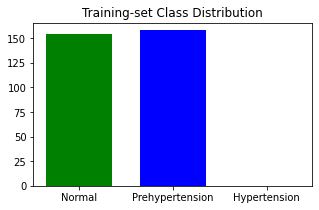

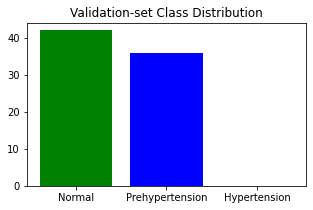

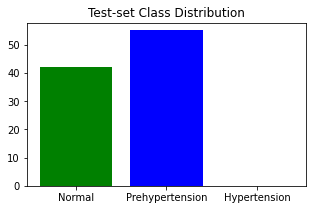

In [78]:
temp_dataloaders={'train': torch.utils.data.DataLoader(data_train,batch_size=1,shuffle=False),
                'val':torch.utils.data.DataLoader(data_val,batch_size=1,shuffle=False),
                'test':torch.utils.data.DataLoader(data_test,batch_size=1,shuffle=False)}

train_labels=[0,0,0]
for data, label, subject in temp_dataloaders['train']:
    if label.data==0:
        train_labels[0]+=1
    elif label.data==1:
        train_labels[1]+=1
    else:
        train_labels[2]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(3),train_labels,color=['g','b','r'],width=0.7)
plt.xticks(np.arange(3),['Normal','Prehypertension','Hypertension'])
plt.title('Training-set Class Distribution')
plt.show()

val_labels=[0,0,0]
for data, label, subject in temp_dataloaders['val']:
    if label.data==0:
        val_labels[0]+=1
    elif label.data==1:
        val_labels[1]+=1
    else:
        val_labels[2]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(3),val_labels,color=['g','b','r'])
plt.xticks(np.arange(3),['Normal','Prehypertension','Hypertension'])
plt.title('Validation-set Class Distribution')
plt.show()

test_labels=[0,0,0]
for data, label, subject in temp_dataloaders['test']:
    if label.data==0:
        test_labels[0]+=1
    elif label.data==1:
        test_labels[1]+=1
    else:
        test_labels[2]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(3),test_labels,color=['g','b','r'])
plt.xticks(np.arange(3),['Normal','Prehypertension','Hypertension'])
plt.title('Test-set Class Distribution')
plt.show()


In [82]:
model = Conv3Net(2).cuda()
#model = CNN_LSTM(2).cuda()
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
binary = False
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
n_epoch = 180
loss = 0
acc = 0
best_acc = 0
for ep in range(n_epoch):
    train_acc, train_loss = train(dataloaders['train'], model, optimizer, ep, criterion, binary)
    val_acc, val_loss = val(dataloaders['val'], model, criterion, binary)
    if val_acc > best_acc:
        state = {
            'epoch': ep + 1,
            'acc': acc,
            'model_state': model.state_dict(),
        }
        best_acc = val_acc
    if (ep + 1) % 60 == 0:
        lr_decay(optimizer, decay_rate=0.1)

model.load_state_dict(state['model_state'])
test_acc, test_loss = val(dataloaders['test'], model, criterion, binary)

Epoch: [1/180]	LR: [0.01]	Loss 0.6914	Acc 0.551
[Val]Loss 0.6428	Acc 0.577
Epoch: [2/180]	LR: [0.01]	Loss 0.6626	Acc 0.558
[Val]Loss 0.6258	Acc 0.590
Epoch: [3/180]	LR: [0.01]	Loss 0.6637	Acc 0.593
[Val]Loss 0.6353	Acc 0.590
Epoch: [4/180]	LR: [0.01]	Loss 0.6469	Acc 0.545
[Val]Loss 0.6588	Acc 0.590
Epoch: [5/180]	LR: [0.01]	Loss 0.6547	Acc 0.622
[Val]Loss 0.6862	Acc 0.551
Epoch: [6/180]	LR: [0.01]	Loss 0.6505	Acc 0.580
[Val]Loss 0.6124	Acc 0.500
Epoch: [7/180]	LR: [0.01]	Loss 0.6436	Acc 0.593
[Val]Loss 0.6925	Acc 0.564
Epoch: [8/180]	LR: [0.01]	Loss 0.6635	Acc 0.535
[Val]Loss 0.6299	Acc 0.603
Epoch: [9/180]	LR: [0.01]	Loss 0.6531	Acc 0.583
[Val]Loss 0.6149	Acc 0.590
Epoch: [10/180]	LR: [0.01]	Loss 0.6369	Acc 0.574
[Val]Loss 0.6387	Acc 0.590
Epoch: [11/180]	LR: [0.01]	Loss 0.6383	Acc 0.590
[Val]Loss 0.6118	Acc 0.577
Epoch: [12/180]	LR: [0.01]	Loss 0.6455	Acc 0.577
[Val]Loss 0.6109	Acc 0.590
Epoch: [13/180]	LR: [0.01]	Loss 0.6366	Acc 0.590
[Val]Loss 0.6295	Acc 0.590
Epoch: [14/180]	LR: [

### Our Results: \["Normal", "hypertension"]

In [60]:
data_mean=2060.61
data_std=285.13
data_normalization = {'mean':data_mean,'std':data_std}

# setup data loader
dataset = BPDataset(ppg_dir, label_path, normalize=data_normalization, choose_class=[0,2])
print('dataset: {}'.format(dataset.__len__()))

# Split training data, validation data, testing data
# [0,1] -> [312, 78, 97]
# [0,2] -> [255, 64, 80]
# [0,1,2]-> [415, 104, 129]
data_train, data_val, data_test = torch.utils.data.random_split(dataset, [255, 64, 80])
print(data_train.__len__())
print(data_val.__len__())
print(data_test.__len__())

dataset: 399
255
64
80


In [61]:
dataloaders={'train': torch.utils.data.DataLoader(data_train,batch_size=10,shuffle=True),
                'val':torch.utils.data.DataLoader(data_val,batch_size=10,shuffle=True),
                'test':torch.utils.data.DataLoader(data_test,batch_size=10,shuffle=False)}
dataset_sizes = {'train': data_train.__len__(),
                    'val':data_val.__len__(),
                    'test':data_test.__len__()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)

Device: cuda


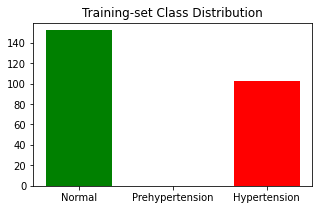

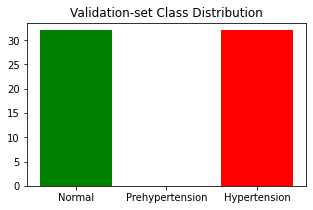

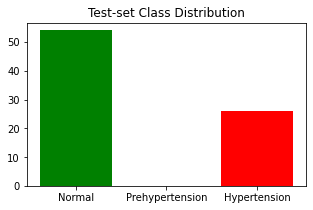

In [62]:
temp_dataloaders={'train': torch.utils.data.DataLoader(data_train,batch_size=1,shuffle=False),
                'val':torch.utils.data.DataLoader(data_val,batch_size=1,shuffle=False),
                'test':torch.utils.data.DataLoader(data_test,batch_size=1,shuffle=False)}

train_labels=[0,0,0]
for data, label, subject in temp_dataloaders['train']:
    if label.data==0:
        train_labels[0]+=1
    elif label.data==1:
        train_labels[1]+=1
    else:
        train_labels[2]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(3),train_labels,color=['g','b','r'],width=0.7)
plt.xticks(np.arange(3),['Normal','Prehypertension','Hypertension'])
plt.title('Training-set Class Distribution')
plt.show()

val_labels=[0,0,0]
for data, label, subject in temp_dataloaders['val']:
    if label.data==0:
        val_labels[0]+=1
    elif label.data==1:
        val_labels[1]+=1
    else:
        val_labels[2]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(3),val_labels,color=['g','b','r'])
plt.xticks(np.arange(3),['Normal','Prehypertension','Hypertension'])
plt.title('Validation-set Class Distribution')
plt.show()

test_labels=[0,0,0]
for data, label, subject in temp_dataloaders['test']:
    if label.data==0:
        test_labels[0]+=1
    elif label.data==1:
        test_labels[1]+=1
    else:
        test_labels[2]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(3),test_labels,color=['g','b','r'])
plt.xticks(np.arange(3),['Normal','Prehypertension','Hypertension'])
plt.title('Test-set Class Distribution')
plt.show()


In [63]:
train_labels

[152, 0, 103]

In [36]:
model = Conv3Net(2).cuda()
#model = CNN_LSTM(2).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
n_epoch = 180
loss = 0
acc = 0
best_acc = 0
for ep in range(n_epoch):
    train_acc, train_loss = train(dataloaders['train'], model, optimizer, ep, criterion)
    val_acc, val_loss = val(dataloaders['val'], model, criterion)
    if val_acc > best_acc:
        state = {
            'epoch': ep + 1,
            'acc': acc,
            'model_state': model.state_dict(),
        }
        best_acc = val_acc
    if (ep + 1) % 60 == 0:
        lr_decay(optimizer, decay_rate=0.1)

model.load_state_dict(state['model_state'])
test_acc, test_loss = val(dataloaders['test'], model, criterion)

Epoch: [1/180]	LR: [0.01]	Loss 0.9511	Acc 0.545
[Val]Loss 0.6713	Acc 0.703
Epoch: [2/180]	LR: [0.01]	Loss 0.7285	Acc 0.576
[Val]Loss 0.6745	Acc 0.703
Epoch: [3/180]	LR: [0.01]	Loss 0.6866	Acc 0.541
[Val]Loss 0.6169	Acc 0.703
Epoch: [4/180]	LR: [0.01]	Loss 0.6670	Acc 0.486
[Val]Loss 0.6194	Acc 0.672
Epoch: [5/180]	LR: [0.01]	Loss 0.7043	Acc 0.525
[Val]Loss 0.7391	Acc 0.391
Epoch: [6/180]	LR: [0.01]	Loss 0.7009	Acc 0.592
[Val]Loss 0.6227	Acc 0.703
Epoch: [7/180]	LR: [0.01]	Loss 0.6884	Acc 0.549
[Val]Loss 0.6015	Acc 0.703
Epoch: [8/180]	LR: [0.01]	Loss 0.6584	Acc 0.545
[Val]Loss 0.6084	Acc 0.703
Epoch: [9/180]	LR: [0.01]	Loss 0.6462	Acc 0.522
[Val]Loss 0.6023	Acc 0.703
Epoch: [10/180]	LR: [0.01]	Loss 0.6454	Acc 0.565
[Val]Loss 0.6702	Acc 0.406
Epoch: [11/180]	LR: [0.01]	Loss 0.6281	Acc 0.596
[Val]Loss 0.5919	Acc 0.703
Epoch: [12/180]	LR: [0.01]	Loss 0.6341	Acc 0.553
[Val]Loss 0.5995	Acc 0.703
Epoch: [13/180]	LR: [0.01]	Loss 0.6303	Acc 0.561
[Val]Loss 0.5963	Acc 0.703
Epoch: [14/180]	LR: [

## Our Model: 3-Class classification (Softmax)
### Our Results: \["Normal", "Prehypertension", "hypertension"]

In [42]:
class Conv3Net(nn.Module):
    def __init__(self, n_class=3):
        super(Conv3Net, self).__init__()
        self.n_class = n_class
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=30, stride=3, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=15, stride=3, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [43]:
data_mean=2060.61
data_std=285.13
data_normalization = {'mean':data_mean,'std':data_std}

# setup data loader
dataset = BPDataset(ppg_dir, label_path, normalize=data_normalization, choose_class=[0,1,2])
print('dataset: {}'.format(dataset.__len__()))

# Split training data, validation data, testing data
# [0,1] -> [312, 78, 97]
# [0,2] -> [255, 64, 80]
# [0,1,2]-> [415, 104, 129]
data_train, data_val, data_test = torch.utils.data.random_split(dataset, [415, 104, 129])
print(data_train.__len__())
print(data_val.__len__())
print(data_test.__len__())

dataset: 648
415
104
129


In [44]:
dataloaders={'train': torch.utils.data.DataLoader(data_train,batch_size=10,shuffle=True),
                'val':torch.utils.data.DataLoader(data_val,batch_size=10,shuffle=True),
                'test':torch.utils.data.DataLoader(data_test,batch_size=10,shuffle=False)}
dataset_sizes = {'train': data_train.__len__(),
                    'val':data_val.__len__(),
                    'test':data_test.__len__()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)

Device: cuda


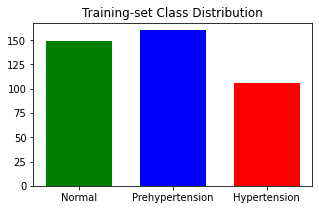

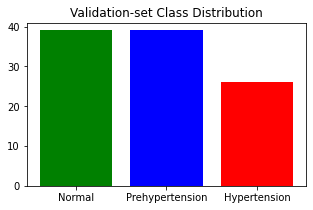

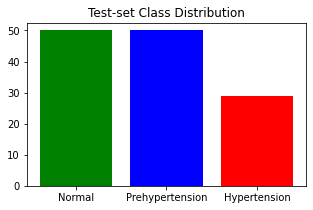

In [45]:
temp_dataloaders={'train': torch.utils.data.DataLoader(data_train,batch_size=1,shuffle=False),
                'val':torch.utils.data.DataLoader(data_val,batch_size=1,shuffle=False),
                'test':torch.utils.data.DataLoader(data_test,batch_size=1,shuffle=False)}

train_labels=[0,0,0]
for data, label, subject in temp_dataloaders['train']:
    if label.data==0:
        train_labels[0]+=1
    elif label.data==1:
        train_labels[1]+=1
    else:
        train_labels[2]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(3),train_labels,color=['g','b','r'],width=0.7)
plt.xticks(np.arange(3),['Normal','Prehypertension','Hypertension'])
plt.title('Training-set Class Distribution')
plt.show()

val_labels=[0,0,0]
for data, label, subject in temp_dataloaders['val']:
    if label.data==0:
        val_labels[0]+=1
    elif label.data==1:
        val_labels[1]+=1
    else:
        val_labels[2]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(3),val_labels,color=['g','b','r'])
plt.xticks(np.arange(3),['Normal','Prehypertension','Hypertension'])
plt.title('Validation-set Class Distribution')
plt.show()

test_labels=[0,0,0]
for data, label, subject in temp_dataloaders['test']:
    if label.data==0:
        test_labels[0]+=1
    elif label.data==1:
        test_labels[1]+=1
    else:
        test_labels[2]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(3),test_labels,color=['g','b','r'])
plt.xticks(np.arange(3),['Normal','Prehypertension','Hypertension'])
plt.title('Test-set Class Distribution')
plt.show()


In [48]:
print(train_labels, val_labels, test_labels)

[149, 160, 106] [39, 39, 26] [50, 50, 29]


In [46]:
model = Conv3Net(3).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
n_epoch = 180
loss = 0
acc = 0
best_acc = 0
for ep in range(n_epoch):
    train_acc, train_loss = train(dataloaders['train'], model, optimizer, ep, criterion)
    val_acc, val_loss = val(dataloaders['val'], model, criterion)
    if val_acc > best_acc:
        state = {
            'epoch': ep + 1,
            'acc': acc,
            'model_state': model.state_dict(),
        }
        best_acc = val_acc
    if (ep + 1) % 60 == 0:
        lr_decay(optimizer, decay_rate=0.1)

model.load_state_dict(state['model_state'])
test_acc, test_loss = val(dataloaders['test'], model, criterion)

Epoch: [1/180]	LR: [0.01]	Loss 1.0831	Acc 0.378
[Val]Loss 1.0601	Acc 0.442
Epoch: [2/180]	LR: [0.01]	Loss 1.0596	Acc 0.410
[Val]Loss 1.0136	Acc 0.404
Epoch: [3/180]	LR: [0.01]	Loss 1.0526	Acc 0.427
[Val]Loss 1.0060	Acc 0.452
Epoch: [4/180]	LR: [0.01]	Loss 1.0265	Acc 0.441
[Val]Loss 1.0091	Acc 0.442
Epoch: [5/180]	LR: [0.01]	Loss 1.0400	Acc 0.419
[Val]Loss 1.0052	Acc 0.442
Epoch: [6/180]	LR: [0.01]	Loss 1.0386	Acc 0.441
[Val]Loss 1.0312	Acc 0.442
Epoch: [7/180]	LR: [0.01]	Loss 1.0166	Acc 0.446
[Val]Loss 1.0648	Acc 0.413
Epoch: [8/180]	LR: [0.01]	Loss 1.0137	Acc 0.436
[Val]Loss 1.0203	Acc 0.433
Epoch: [9/180]	LR: [0.01]	Loss 1.0072	Acc 0.446
[Val]Loss 1.0246	Acc 0.404
Epoch: [10/180]	LR: [0.01]	Loss 1.0124	Acc 0.441
[Val]Loss 1.0128	Acc 0.404
Epoch: [11/180]	LR: [0.01]	Loss 1.0004	Acc 0.441
[Val]Loss 1.0285	Acc 0.394
Epoch: [12/180]	LR: [0.01]	Loss 0.9875	Acc 0.484
[Val]Loss 1.0941	Acc 0.394
Epoch: [13/180]	LR: [0.01]	Loss 1.0153	Acc 0.453
[Val]Loss 1.0946	Acc 0.279
Epoch: [14/180]	LR: [